Ноутбук с замерами времени, уходящими на построение и сопоставление круговых диаграмм с разной мелкостью разбиения. Нужен, чтобы получить графики для текста диплома. Графики должны получиться следующие:

- среднее время построения одной диаграммы в зависимости от количества квадратов по самой длинной стороне изображения (bigger_side_blocks_count)
- среднее время сопоставления двух диаграмм (агента и любой другой)

Всего 2 графика

In [58]:
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import time

In [24]:
import sys
sys.path.append('..')
from rectangles_drawing import calculate_one_pixels_diffs, draw_all_rectangles
from osm_object import Image_OSM_object

from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import Image_circle_diagrams
from circle_diagram import calculate_penalty_for_diagrams

from utils import read_pickle, dump_pickle

In [3]:
points = read_pickle('../dataset/100_random_points.pickle')
points_to_centers_6_8 = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')
points_to_centers_3_4 = read_pickle('../dataset/100_points_to_cell_centers_12cells_3x4.pickle')

In [4]:
predictions_folder = '../dataset/predictions/'
predicts_osm_folder = 'predicts_osm'
rectangled_predicts_folder = 'rectangled_predicts_pixel'
objects_predicts_folder = 'rectangled_predicts_obj'

osm_objects_path = os.path.join(predictions_folder, predicts_osm_folder)

In [5]:
train_val_test = read_pickle("../dataset/train_val_test_split.pickle")
test_ids = train_val_test['test']

In [21]:
img_ids = test_ids[:10]

In [20]:
def calculate_cells_probs(img_cds, agent_cd):
    """
    only fast version
    """
    penalties = []
    
    for i in range(len(img_cds.center_points)):
#         penalties.append(img_cds.fast_diagrams[i].dist_to(agent_cd.fast_diagram))
        penalties.append(calculate_penalty_for_diagrams(img_cds.circle_diagrams[i].sectors, agent_cd.sectors))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()

In [46]:
def calc_time_one_img(img_id, bigger_side_blocks_count, sectors_count):
    times_create = []
    times_match = []
    
    filename_pickle = img_id + '.pickle'

    img_osm = read_pickle(os.path.join(osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    
    start_time = time.time()
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=False)
    end_time = time.time()
    times_create_img_cds = (end_time - start_time) / len(img_cds.center_points)
    
    for agent_point in points:
        agent_point = agent_point[::-1]
        
        start_time = time.time()
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm)
        end_time = time.time()
        times_create.append((end_time - start_time))
        
        start_time = time.time()
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        end_time = time.time()
        times_match.append((end_time - start_time))
        
    return times_create_img_cds, times_create, times_match

In [47]:
calc_time_one_img(img_ids[0], 8, 616)

(0.0009846935669581096,
 [0.0011799335479736328,
  0.0011870861053466797,
  0.0008890628814697266,
  0.0008563995361328125,
  0.0008428096771240234,
  0.0012142658233642578,
  0.0009307861328125,
  0.0008525848388671875,
  0.0008487701416015625,
  0.0008893013000488281,
  0.0008716583251953125,
  0.0008466243743896484,
  0.0008606910705566406,
  0.0008413791656494141,
  0.0008573532104492188,
  0.0008966922760009766,
  0.0009446144104003906,
  0.0009210109710693359,
  0.0008928775787353516,
  0.0008471012115478516,
  0.0008540153503417969,
  0.0008473396301269531,
  0.000850677490234375,
  0.0008473396301269531,
  0.0009076595306396484,
  0.0008521080017089844,
  0.0008449554443359375,
  0.0008339881896972656,
  0.0008959770202636719,
  0.0009074211120605469,
  0.0008563995361328125,
  0.00084686279296875,
  0.0008704662322998047,
  0.0023021697998046875,
  0.0009045600891113281,
  0.0009002685546875,
  0.0008695125579833984,
  0.0008478164672851562,
  0.00092315673828125,
  0.00089669

In [34]:
def calc_time(bigger_side_blocks_count):

    sectors_count = calculate_sectors_count(bigger_side_blocks_count)
    print("Sectors count:", sectors_count)
    
    times_img_cds = []
    times_agent_cds_create = []
    times_match = []
    
    for img_id in img_ids:
        print(img_id)
        times_create_img_cds_cur, times_create_cur, times_match_cur = calc_time_one_img(img_id,
                                                                                    bigger_side_blocks_count,
                                                                                    sectors_count)
        times_img_cds.append(times_create_img_cds_cur)
        times_agent_cds_create.append(np.array(times_create_cur).mean())
        times_match.append(np.array(times_match_cur).mean())
    
    return np.array(times_img_cds).mean(), np.array(times_agent_cds_create).mean(), np.array(times_match).mean()

In [48]:
img_cds_4, agent_cds_4, match_4 = calc_time(4)
print("Img cds:", img_cds_4, "seconds")
print("Agent cds:", agent_cds_4, "seconds")
print("Match cds:", match_4, "seconds")

Sectors count: 114
20327
9501
3138
7130
10196
10798
11093
11980
15300
14346
Img cds: 0.0014721095561981202 seconds
Agent cds: 0.0016367061138153078 seconds
Match cds: 0.0013395061492919923 seconds


In [49]:
%%time
img_cds_8, agent_cds_8, match_8 = calc_time(8)
print("Img cds:", img_cds_8, "seconds")
print("Agent cds:", agent_cds_8, "seconds")
print("Match cds:", match_8, "seconds")

Sectors count: 616
20327
9501
3138
7130
10196
10798
11093
11980
15300
14346
Img cds: 0.0021315644184748328 seconds
Agent cds: 0.002070412874221802 seconds
Match cds: 0.03138631892204284 seconds
CPU times: user 34.6 s, sys: 44 ms, total: 34.6 s
Wall time: 34.5 s


In [50]:
%%time
img_cds_16, agent_cds_16, match_16 = calc_time(16)
print("Img cds:", img_cds_16, "seconds")
print("Agent cds:", agent_cds_16, "seconds")
print("Match cds:", match_16, "seconds")

Sectors count: 2828
20327
9501
3138
7130
10196
10798
11093
11980
15300
14346
Img cds: 0.004492548108100891 seconds
Agent cds: 0.003317877054214478 seconds
Match cds: 0.544834328174591 seconds
CPU times: user 9min 16s, sys: 523 ms, total: 9min 17s
Wall time: 9min 16s


In [57]:
%%time
img_cds_20, agent_cds_20, match_20 = calc_time(20)
print("Img cds:", img_cds_20, "seconds")
print("Agent cds:", agent_cds_20, "seconds")
print("Match cds:", match_20, "seconds")

Sectors count: 4537
20327
9501
3138
7130
10196
10798
11093
11980
15300
14346
Img cds: 0.006401459932327271 seconds
Agent cds: 0.005414812088012695 seconds
Match cds: 1.4465428063869474 seconds
CPU times: user 24min 30s, sys: 1.08 s, total: 24min 31s
Wall time: 24min 31s


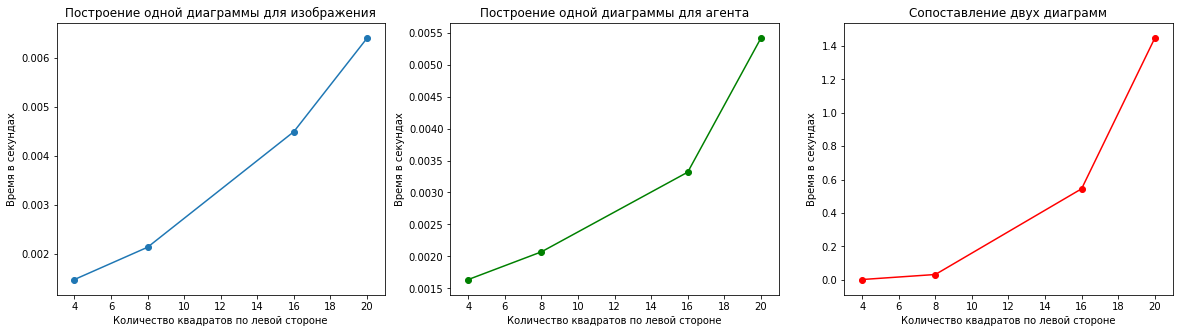

In [73]:
big_side_blocks = [4, 8, 16, 20]
img_cds_means = [img_cds_4, img_cds_8, img_cds_16, img_cds_20]
img_agent_means = [agent_cds_4, agent_cds_8, agent_cds_16, agent_cds_20]
match_means = [match_4, match_8, match_16, match_20]

plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.plot(big_side_blocks, img_cds_means)
plt.scatter(big_side_blocks, img_cds_means)
plt.xlabel('Количество квадратов по левой стороне')
plt.ylabel('Время в секундах')
plt.title('Построение одной диаграммы для изображения')

plt.subplot(132)
plt.plot(big_side_blocks, img_agent_means, color='green')
plt.scatter(big_side_blocks, img_agent_means, color='green')
plt.xlabel('Количество квадратов по левой стороне')
plt.ylabel('Время в секундах')
plt.title('Построение одной диаграммы для агента')

plt.subplot(133)
plt.plot(big_side_blocks, match_means, color='red')
plt.scatter(big_side_blocks, match_means, color='red')
plt.xlabel('Количество квадратов по левой стороне')
plt.ylabel('Время в секундах')
plt.title('Сопоставление двух диаграмм')++


plt.show()

Графики, характеризующие дообучение yolov3

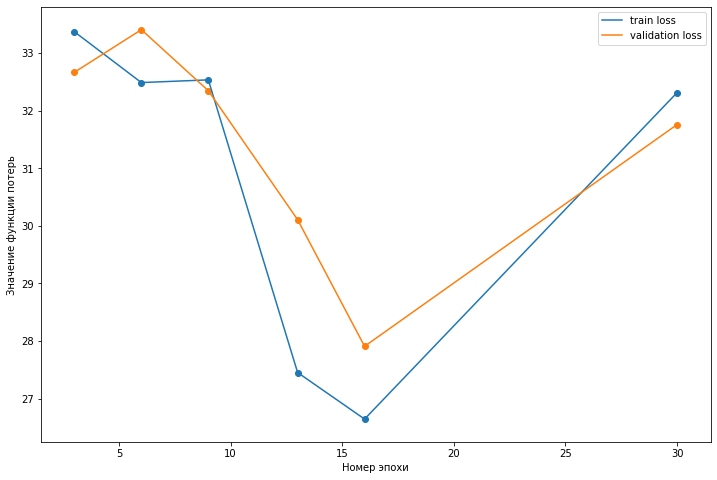

In [80]:

epoch_num = [3, 6, 9, 13, 16, 30]
loss = [33.373, 32.490, 32.537, 27.453, 26.644, 32.316]
val_loss = [32.669, 33.409, 32.349, 30.108, 27.908, 31.761]

plt.figure(figsize=(12, 8))
plt.plot(epoch_num, loss, label='train loss')
plt.scatter(epoch_num, loss)
plt.plot(epoch_num, val_loss, label='validation loss')
plt.scatter(epoch_num, val_loss)

plt.xlabel('Номер эпохи')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.show()

Нужна красивая картинка с предсказанием хребтов.

In [3]:
import os
from keras.models import load_model

In [4]:
autoencoder = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_ridge_satellite.h5'))






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [5]:
import pickle
import keras
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [6]:
with open('../dataset/train_val_test_split.pickle', 'rb') as f:
    train_val_test = pickle.load(f)

In [7]:
train_filenames = train_val_test['train']
validate_filenames = train_val_test['validate']
test_filenames = train_val_test['test']

In [8]:
maps_folder = '../dataset/map/'
satellites_folder = '../dataset/satellite/'
masks_folder = '../dataset/masks/'

In [9]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, list_IDs, X_path='../dataset/map/', Y_path='../dataset/masks/', classid=0,
                 batch_size=32, dim=(300,400), shuffle=True):
        'Initialization'
        self.list_IDs = list_IDs
        self.X_path=X_path
        self.Y_path=Y_path
        self.classid = classid
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()
        
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
        
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 3))
        Y = np.empty((self.batch_size, *self.dim, 1))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = cv2.imread(os.path.join(self.X_path, ID + '.png')) / 255.
            Y[i,] = (np.load(os.path.join(self.Y_path, ID + '.npy'))[self.classid]).reshape((*self.dim, 1))

        return X, Y
    
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

In [10]:
validation_generator_satellite_ridge = DataGenerator(
    validate_filenames,
    X_path=satellites_folder,
    Y_path=masks_folder,
    classid=4,
    batch_size=10
)

In [11]:
def show_all(i, thresh=0.15):
    plt.figure(figsize=(20, 25))

    plt.subplot(141)
    plt.imshow(np.stack([x[i][:,:,2], x[i][:,:,1], x[i][:,:,0]], axis=2))

    plt.subplot(142)
    plt.imshow(y[i].reshape((300, 400)))

    plt.subplot(143)
    plt.imshow(pred[i].reshape((300, 400)))

    plt.subplot(144)
    plt.imshow(pred[i].reshape((300, 400)) >= thresh)

    plt.show()

In [14]:
x, y = validation_generator_satellite_ridge.__getitem__(0)

Hey!
3 0


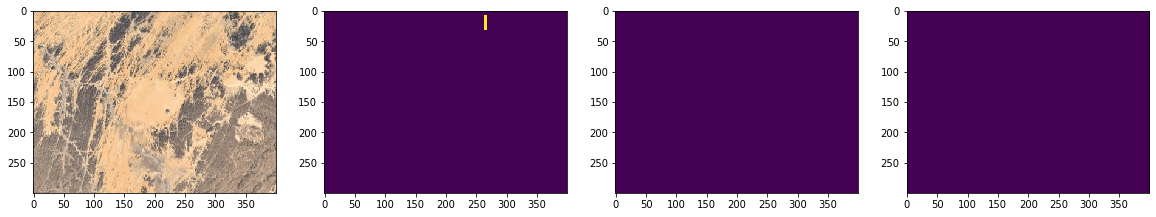

Hey!
4 3


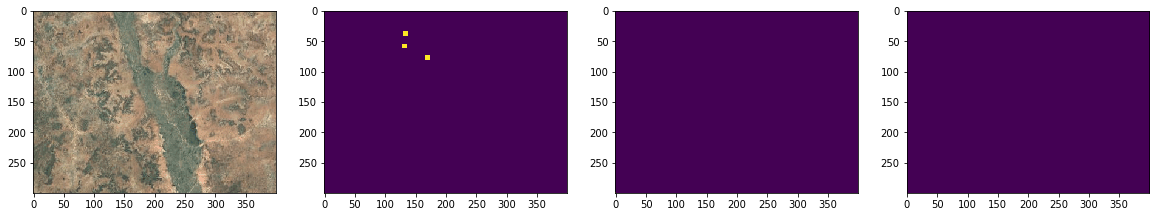

Hey!
4 9


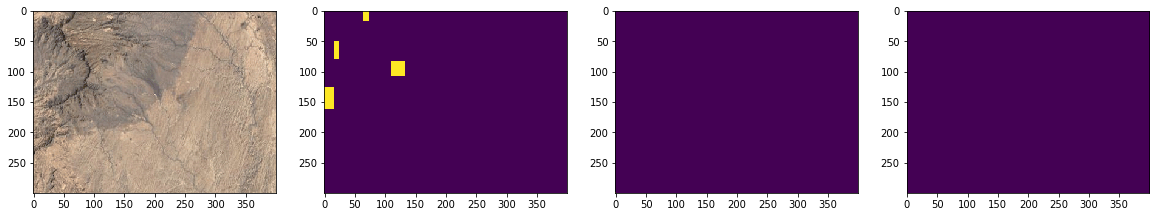

Hey!
5 3


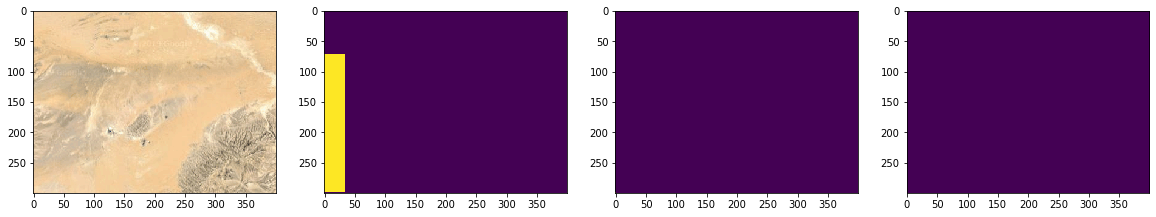

Hey!
6 2


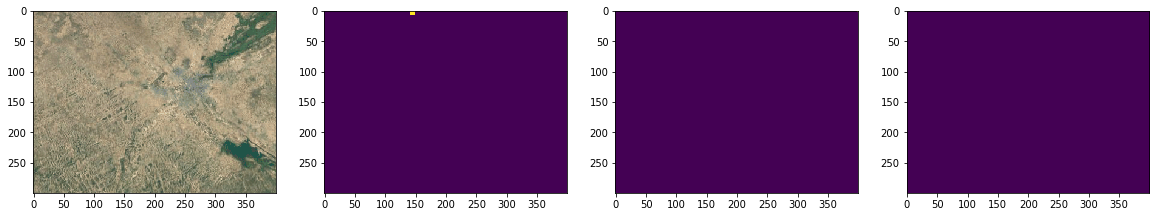

Hey!
7 0


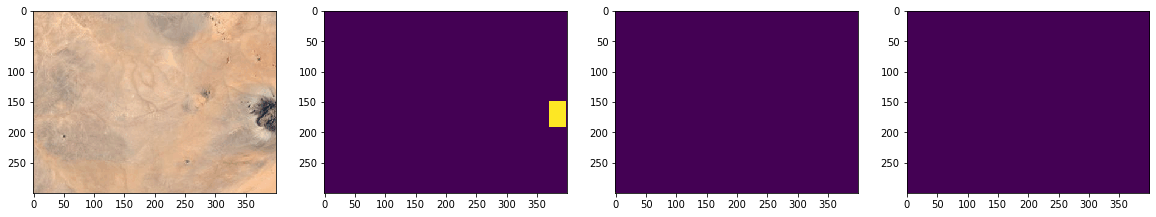

Hey!
8 8


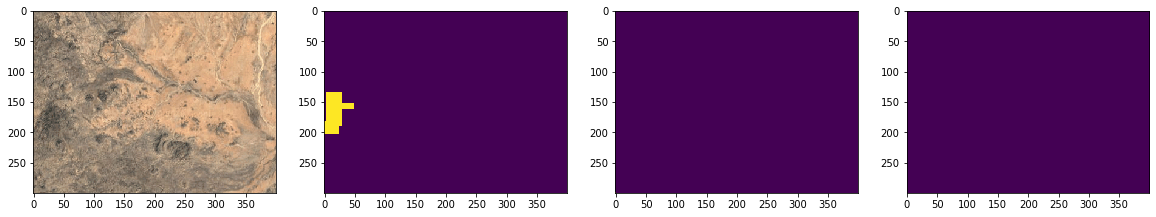

Hey!
11 0


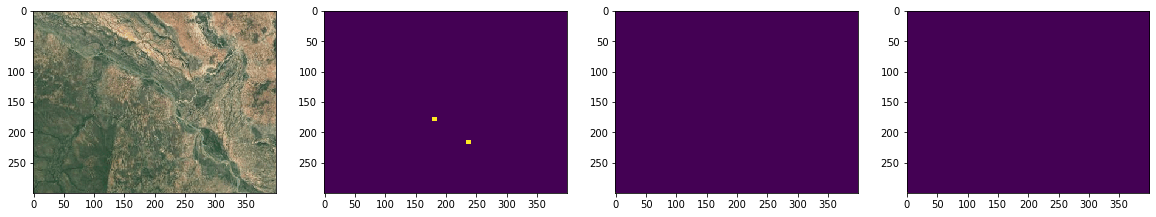

Hey!
11 1


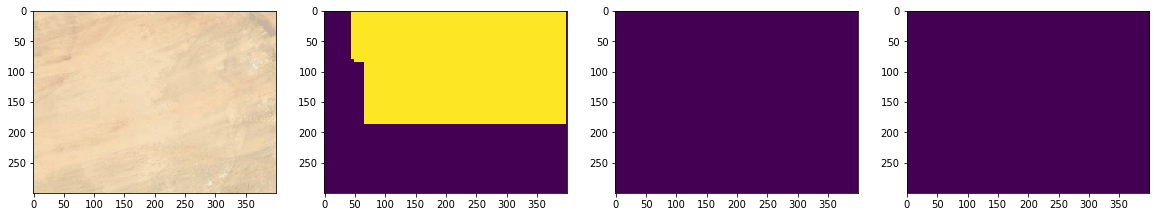

Hey!
11 9


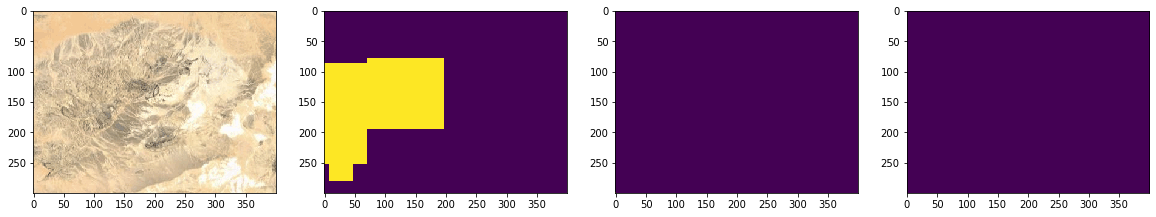

Hey!
12 9


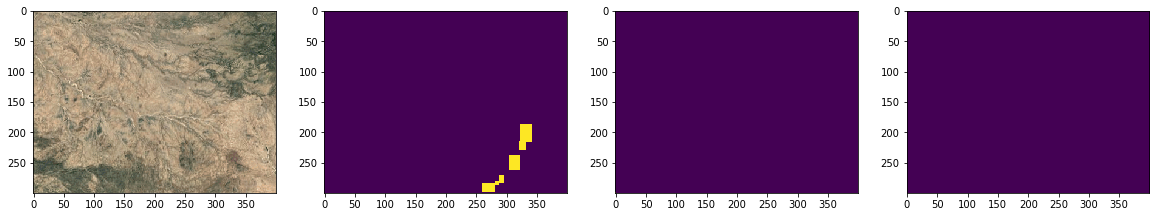

Hey!
13 0


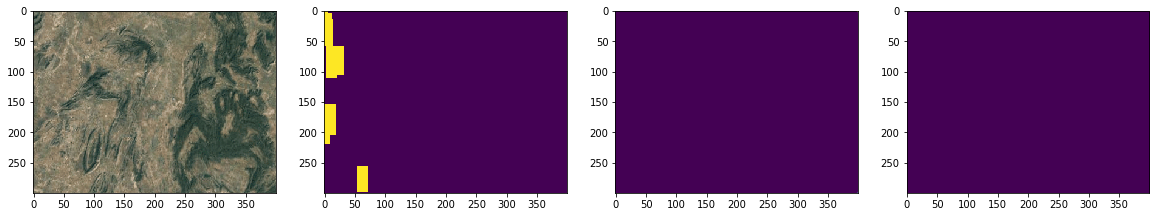

Hey!
14 6


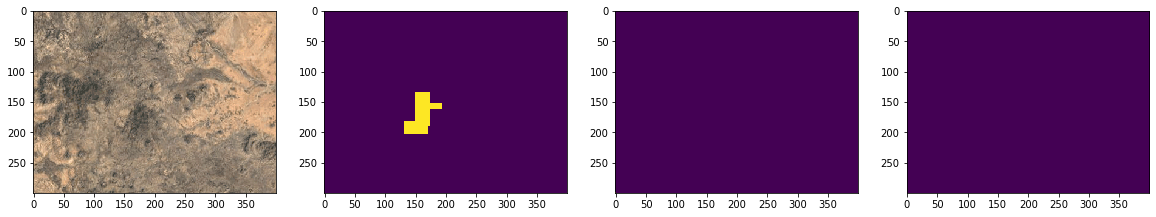

Hey!
14 7


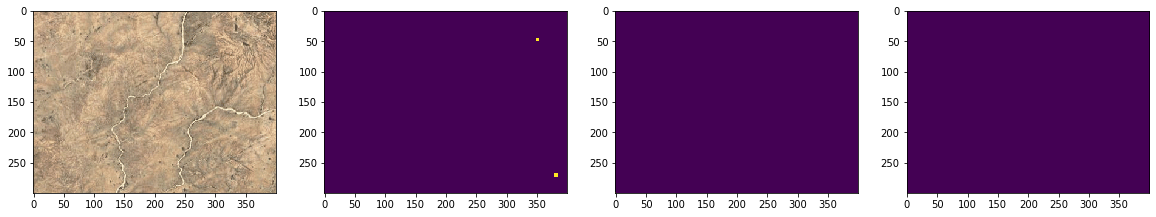

Hey!
15 9


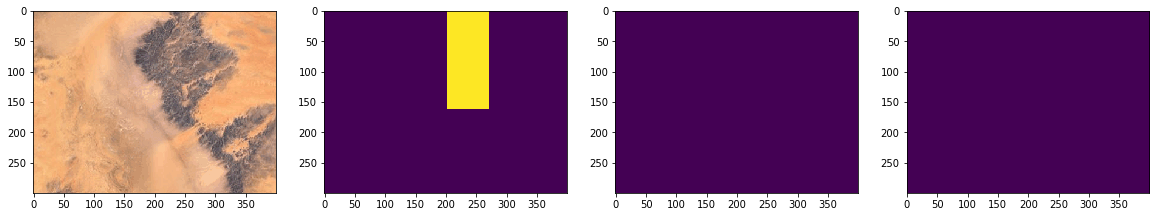

Hey!
18 9


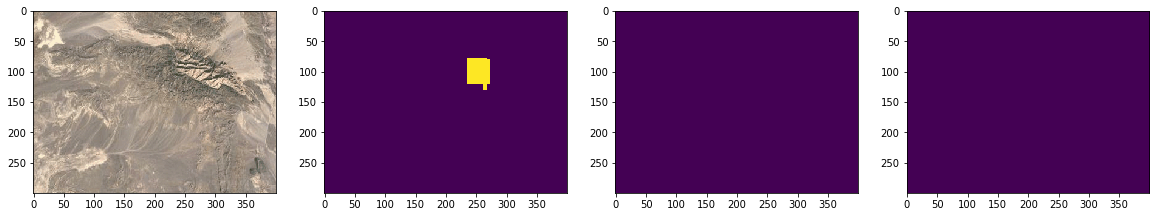

Hey!
22 0


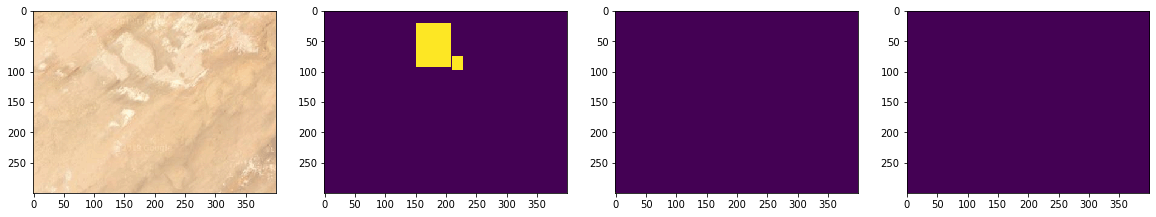

Hey!
23 2


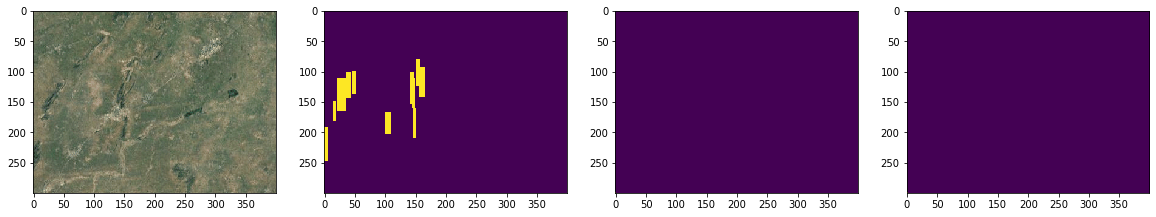

Hey!
25 2


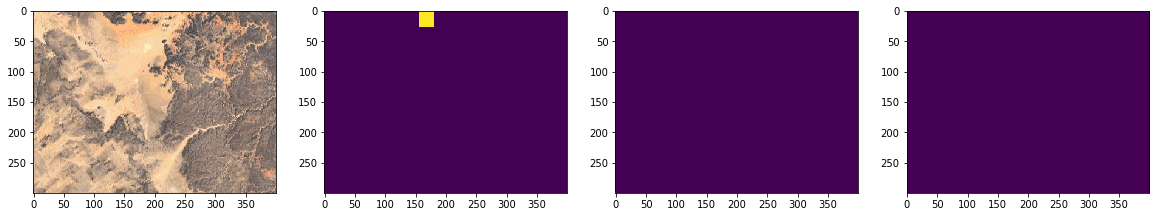

Hey!
26 0


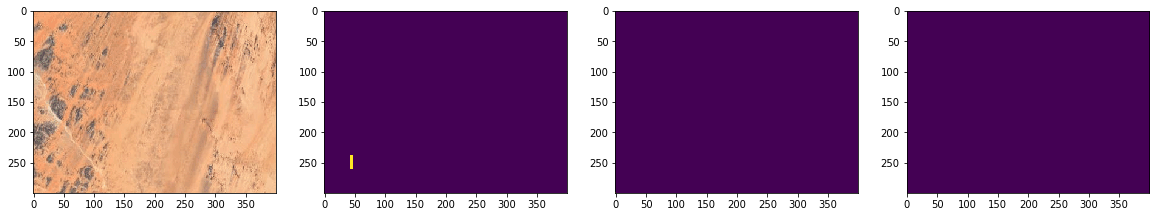

Hey!
26 6


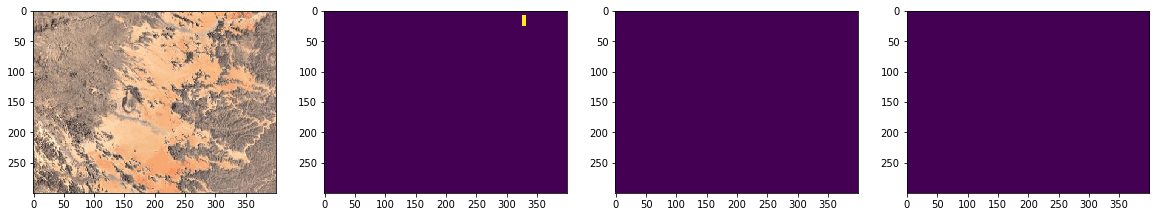

Hey!
26 9


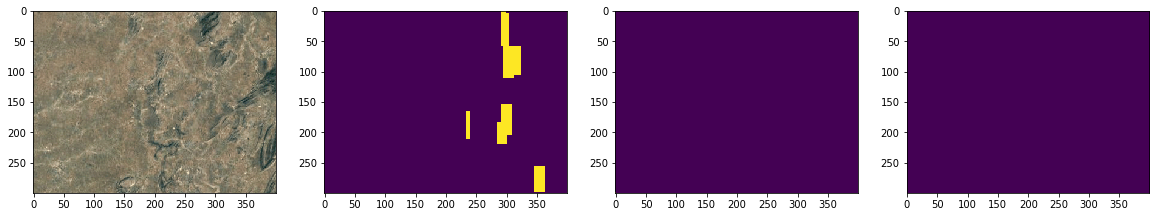

Hey!
28 1


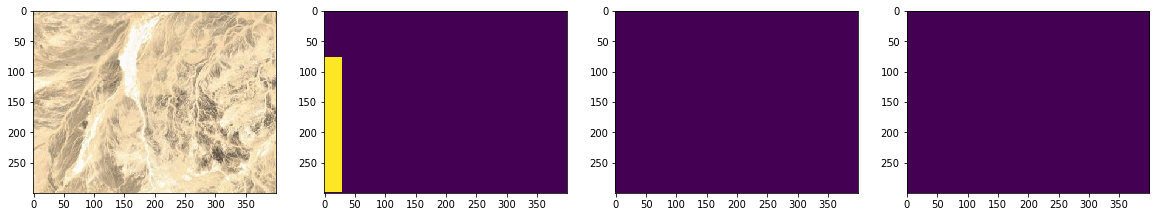

Hey!
28 3


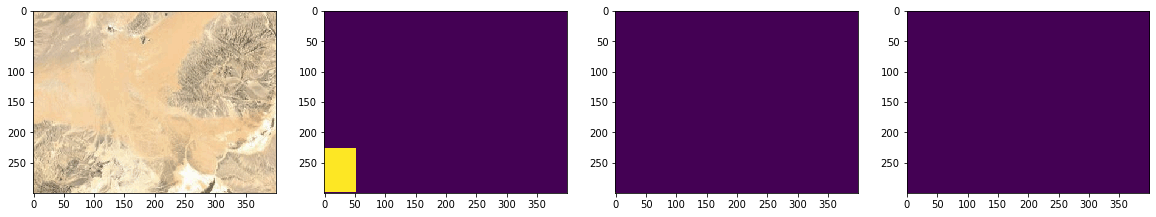

Hey!
28 5


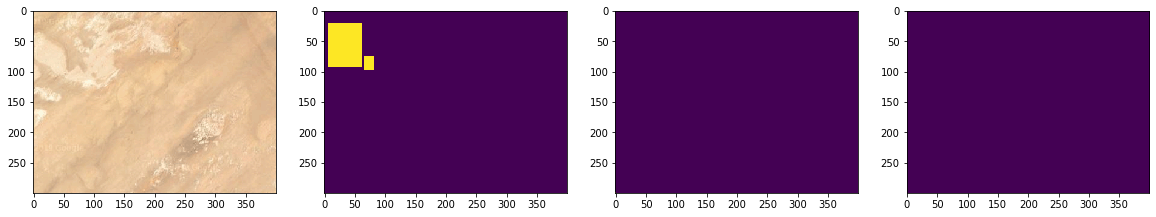

Hey!
28 7


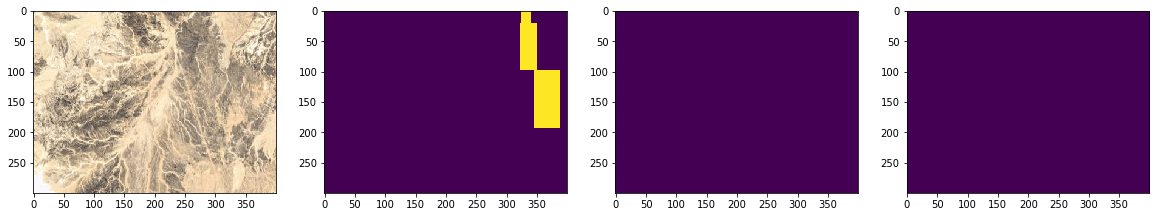

Hey!
29 9


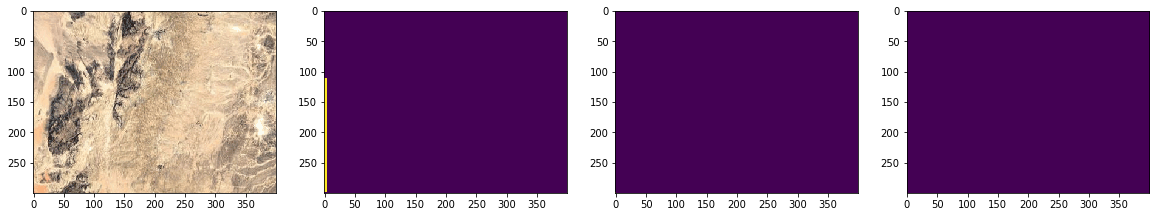

Hey!
32 2


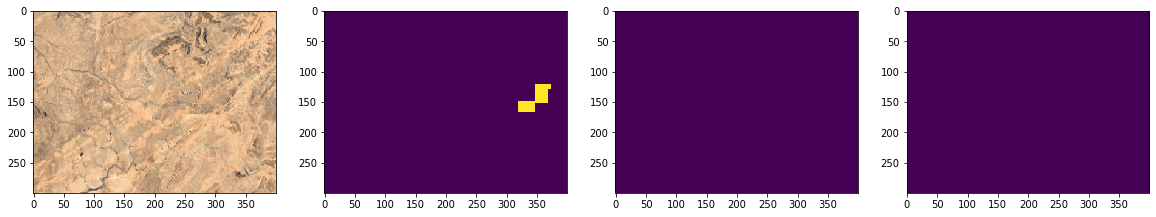

Hey!
33 0


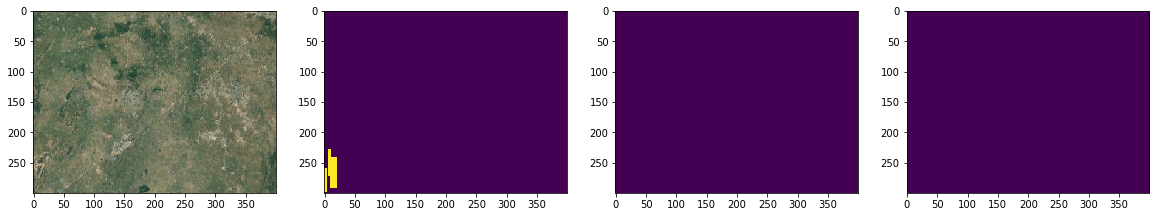

Hey!
35 1


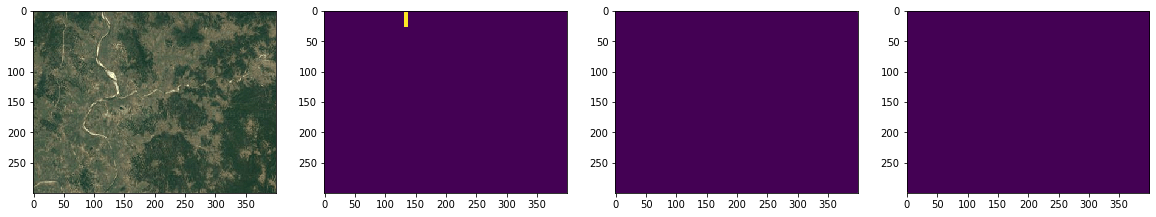

Hey!
35 6


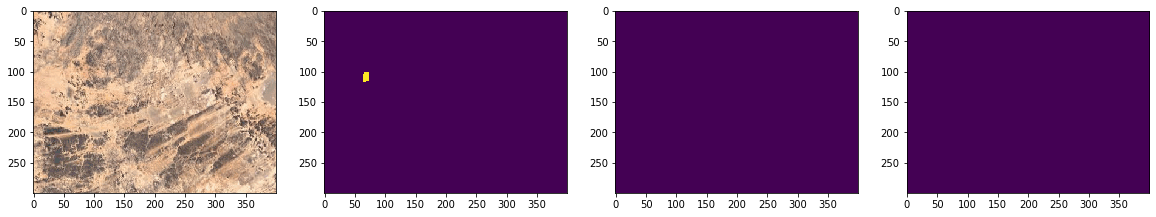

Hey!
41 1


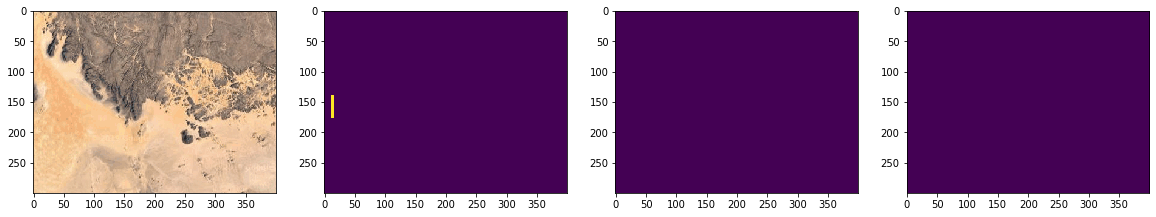

Hey!
42 9


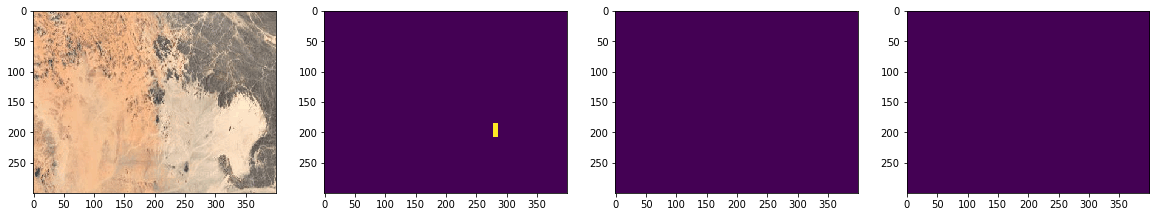

Hey!
45 4


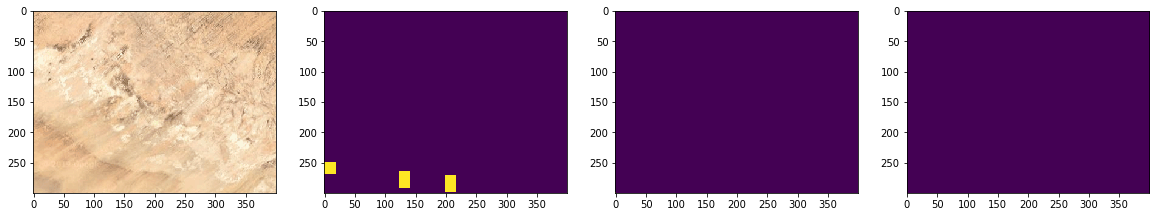

Hey!
46 1


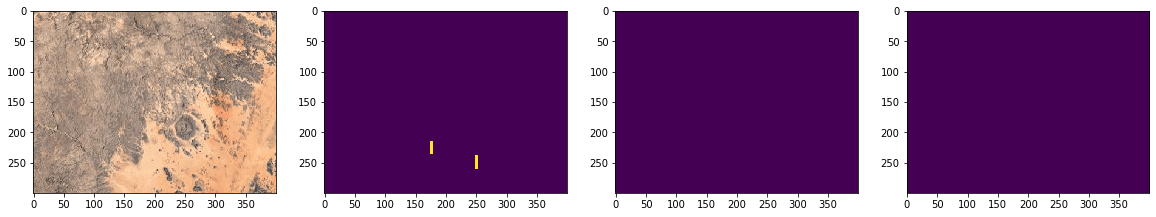

Hey!
46 3


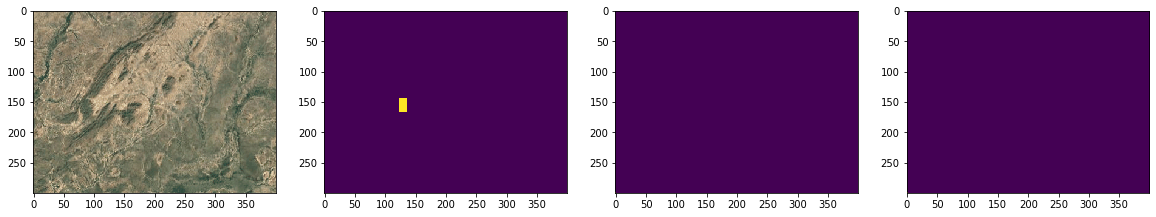

Hey!
50 2


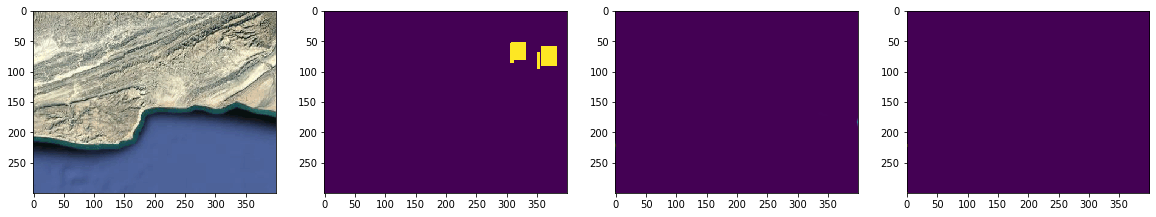

Hey!
50 6


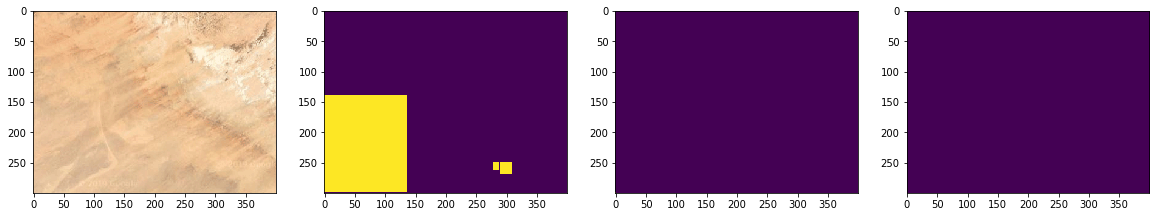

Hey!
53 9


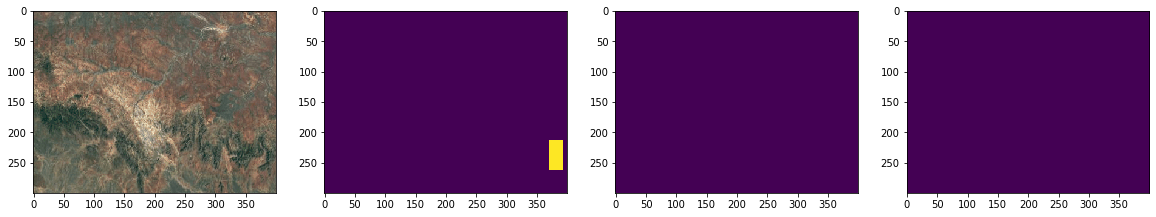

Hey!
54 6


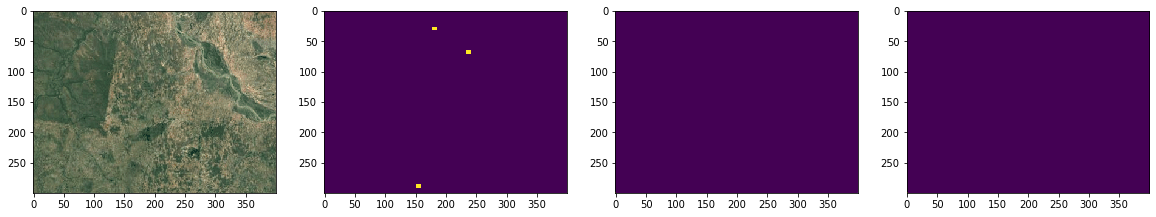

Hey!
55 5


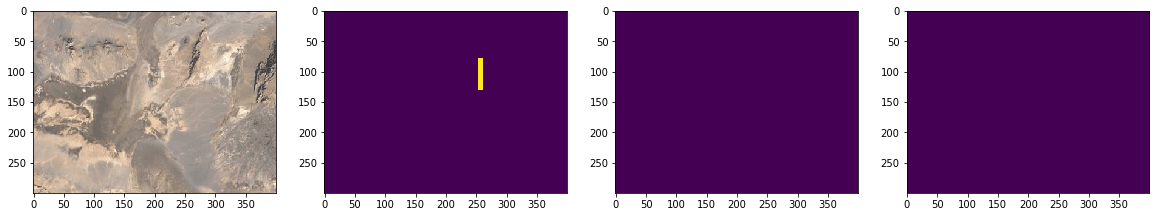

Hey!
60 0


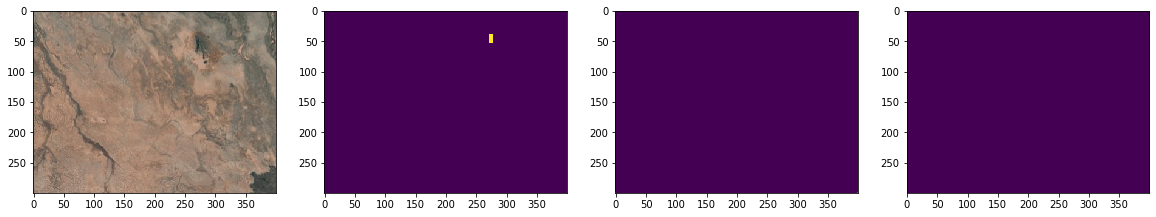

Hey!
62 6


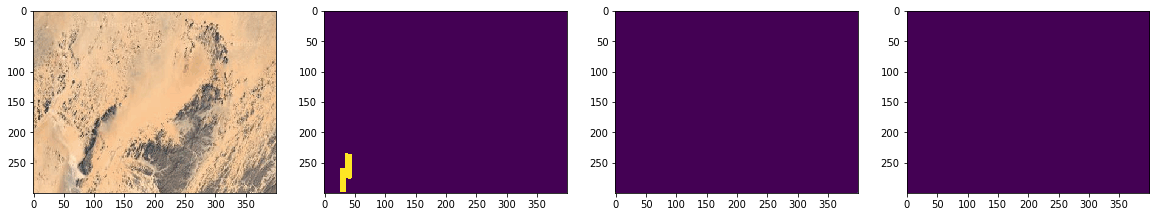

Hey!
64 2


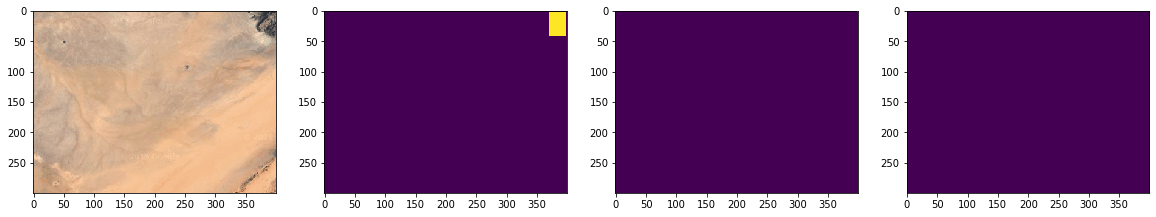

Hey!
65 2


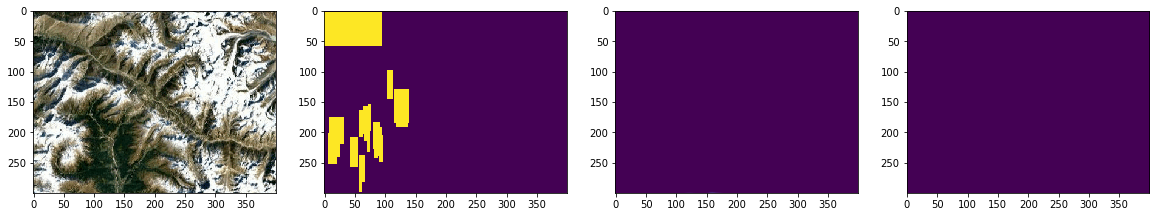

Hey!
66 6


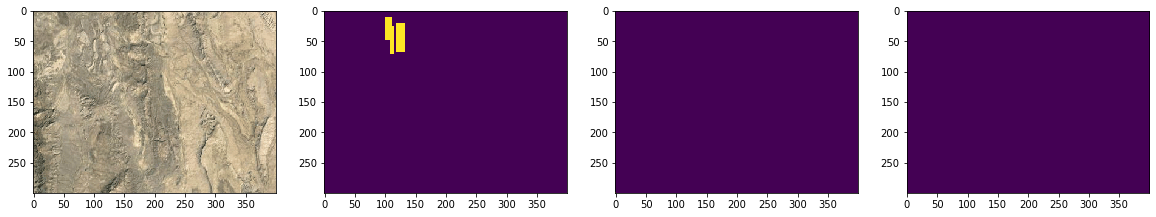

Hey!
72 2


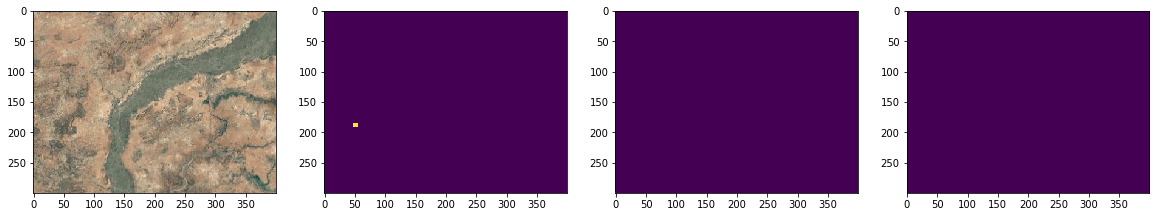

Hey!
76 3


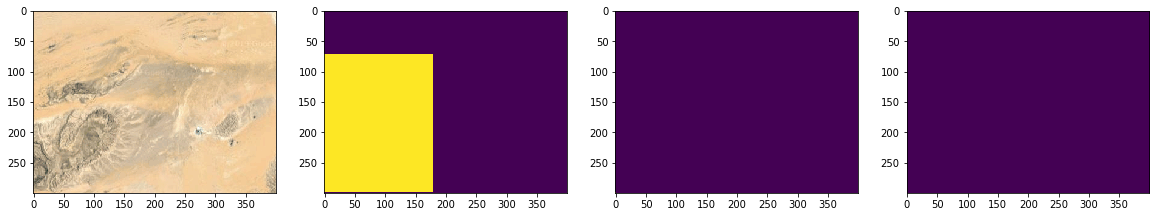

Hey!
78 6


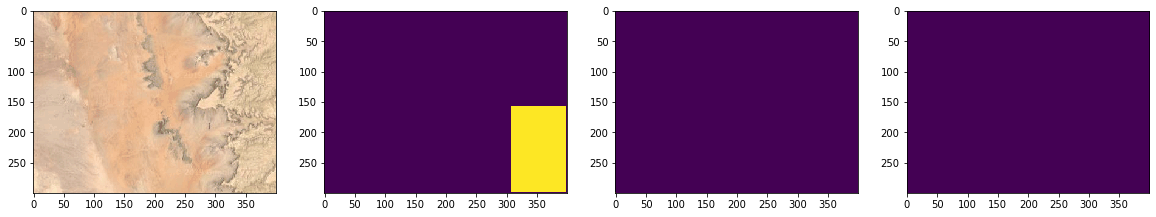

Hey!
87 9


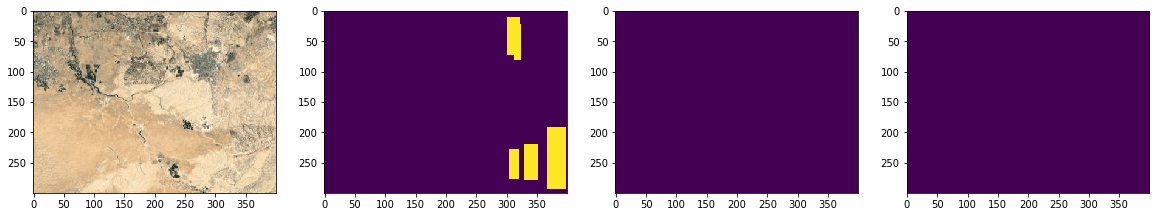

Hey!
88 2


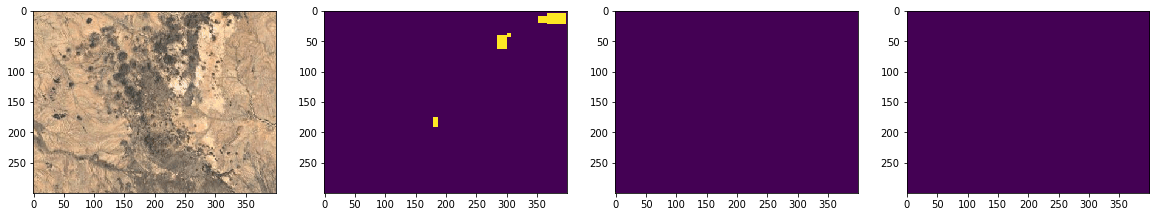

Hey!
89 7


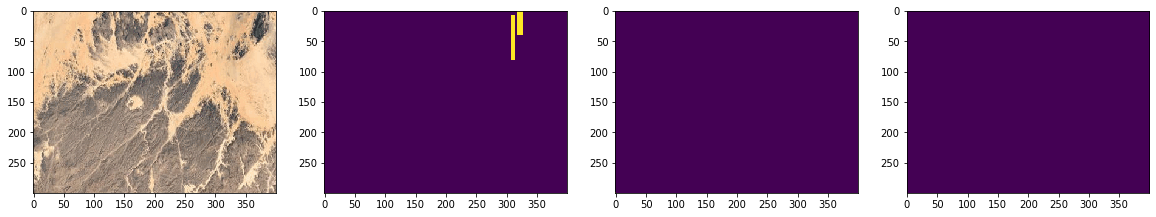

Hey!
93 2


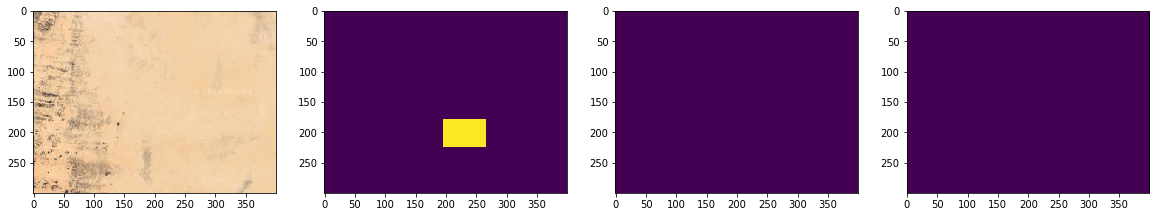

Hey!
93 4


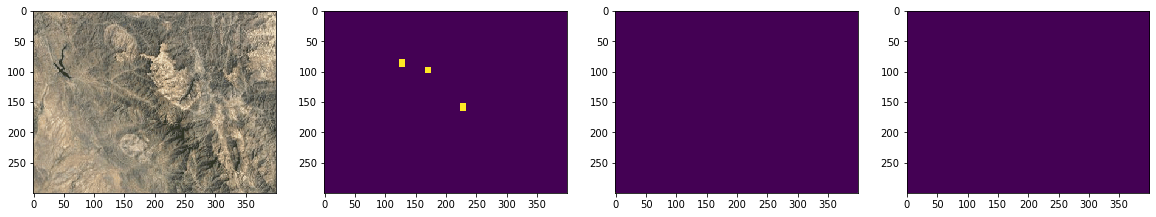

Hey!
93 5


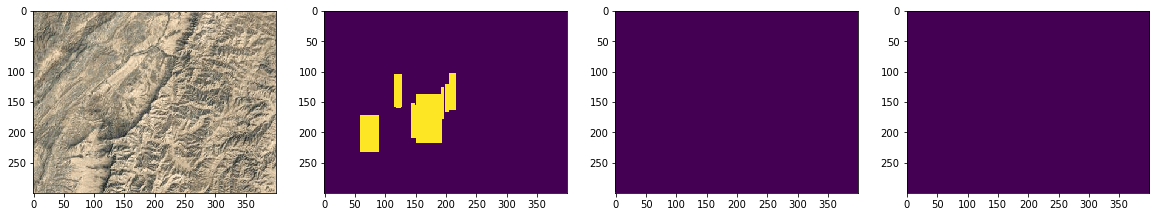

Hey!
93 9


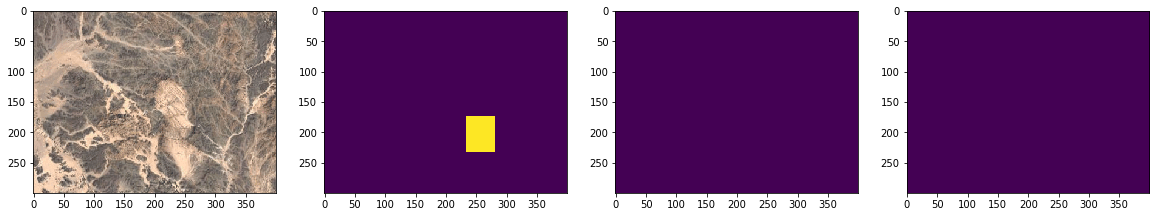

Hey!
94 3


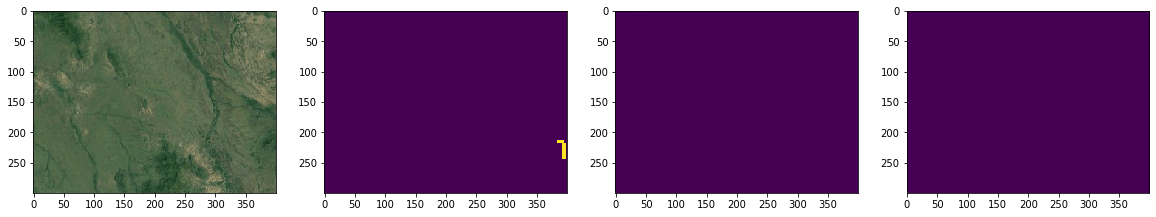

Hey!
98 2


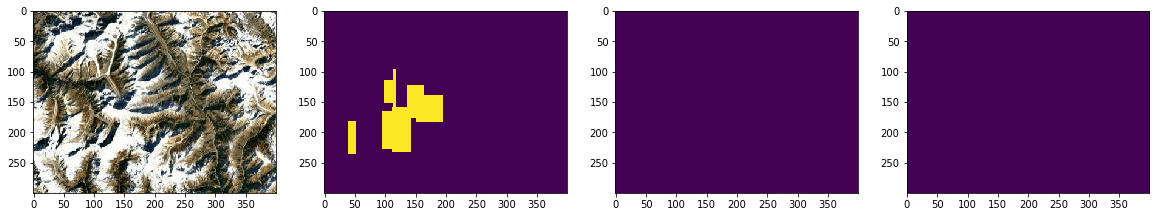

In [17]:
for i in range(100):
    x, y = validation_generator_satellite_ridge.__getitem__(i)
    pred = autoencoder.predict(x)
    
    for j in range(10):
        if np.sum(y[j] >= 0.02) > 1:
        
#         if np.sum(pred[j] >= 0.02) > 10:
            print("Hey!")
            print(i, j)
            
            show_all(j, thresh=0.02)


In [6]:
10 / 48

0.20833333333333334